In [11]:
import ssl
import urllib.request
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.nn import functional as F
%load_ext autoreload

%autoreload 2

ssl._create_default_https_context = ssl._create_unverified_context
from src.anti_spoof.fas import flip_it

from deepface import DeepFace
import re

import streamlit as st

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
model = flip_it()
model_path = "pretrained_models/casia_flip_mcl.pth.tar"
checkpoint = torch.load(model_path, map_location="cpu")
model.load_state_dict(checkpoint["state_dict"], strict=False)
model.eval()

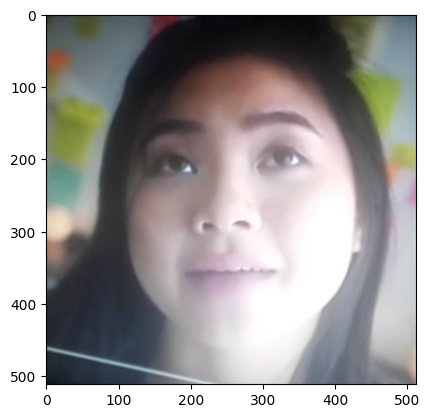

In [19]:
# img1_path = "../spoof/spoof/spoof_314.png"
# img = Image.open(img1_path)
# plt.imshow(img)

In [3]:
preprocess = transforms.Compose(
[
transforms.Resize([224, 224]),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485], std=[0.229])
]
)

In [7]:
def authorise_user(image_path):
    print('\n-------------- Authorisation --------------\n')

    # anti spoof
    img = Image.open(image_path)

    input = preprocess(img).unsqueeze(0)
    cls_out, feature = model(input, norm_flag=True)
    prob = F.softmax(cls_out, dim=1).cpu().data.numpy()

    spoof_result = ((prob[:, 1])>= 0.5).astype(int)[0]

    if spoof_result==0:
        print('Authorisation DENIED, spoof detected')
    
    elif spoof_result==1:
        result = DeepFace.find(image_path, db_path='./database')

        distance = result[0]['distance'][0]
        person = ' '.join((result[0]['identity'][0]).split('\\')[-1].split('_')[:2])
        max_distance = 0.5

        print(f'Distance: {distance}')
        if distance <= max_distance:
            print(f'Authorisation confirmed. Welcome {person}!')
        else:
            print('Authorisation DENIED')
            
        return result

In [8]:
result = authorise_user('../dataset/Adam_Sandler/test_positive/Adam_Sandler_1088_560.jpeg')



-------------- Authorisation --------------

24-06-14 20:00:33 - Searching ../dataset/Adam_Sandler/test_positive/Adam_Sandler_1088_560.jpeg in 5323 length datastore
24-06-14 20:00:41 - find function duration 15.192797899246216 seconds
Distance: 0.09274071399858375
Authorisation confirmed. Welcome Adam Sandler!


In [12]:
# Streamlit app layout
st.title('User Authentication System')
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image.', use_column_width=True)
    st.write("")
    if st.button('Authorise'):
        # Save the uploaded file to a temporary file to process it
        with open("temp_image.jpg", "wb") as f:
            f.write(uploaded_file.getbuffer())
        
        result = authorise_user("temp_image.jpg")
        st.write(result)

2024-06-14 20:12:35.339 
  command:

    streamlit run c:\Users\daria\VSCode\biometria\lab3\venv\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
